### Тема: Проверка гипотез о законе распределения, проблема нормализации выборки

**Выполнил**: Лежнин Максим Витальевич (ПМ-31)

**Преподаватель**: Олейник Т.А., кафедра ВМ-1

###### Практическая работа № **7**, вариант № **3**

###### Осенний семестр, 2023 год

###### МИЭТ, Зеленоград

### Библиотеки

In [3]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn

### Задание 1
В файле «Data_7_1» приведены массивы результатов наблюдения нескольких случайных величин. Будем рассматривать каждый из массивов как случайную выборку из генеральной совокупности с неизвестным законом распределения (для каждого массива генеральная совокупность своя). Экспортируйте данные. Для каждой из выборок постройте гистограмму относительных частот и на основе визуального качественного анализа гистограмм отберите три выборки: выборку А,
позволяющую выдвинуть гипотезу о принадлежности нормальному распределению генеральной совокупности; выборку В, позволяющую выдвинуть гипотезу о равномерном распределении генеральной совокупности; выборку С, позволяющую выдвинуть гипотезу о показательном распределении генеральной совокупности.

Если среди массивов данных нет ни одного похожего на выборку из генеральной совокупности с показательным законом распределения, то попробуйте преобразовать один из них таким образом, чтобы к полученной выборке гипотеза о показательном распределении генеральной совокупности подходила.

In [4]:
# конвертирую лист строк в лист float'ов
def parse_sample(sample, ignoring=0):
    new_sample = []
    for i in sample:
        if i == '-':
            continue
    
        elif i == 0:
            if ignoring:
                continue
            new_sample.append(0)

        else:
            new_sample.append(float(i))

    return new_sample

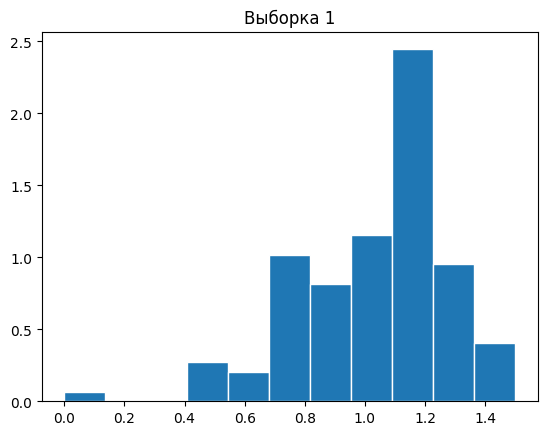

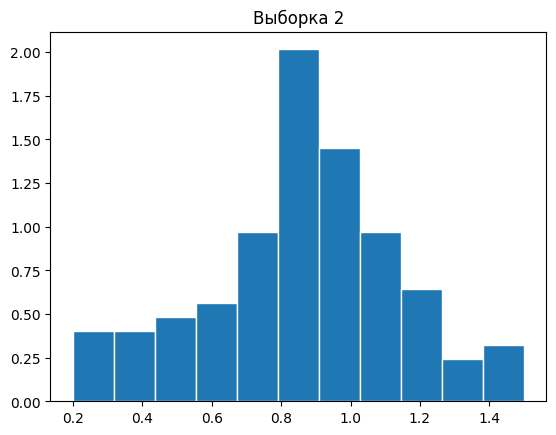

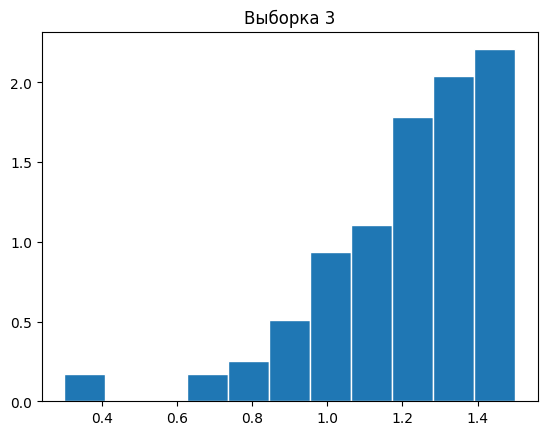

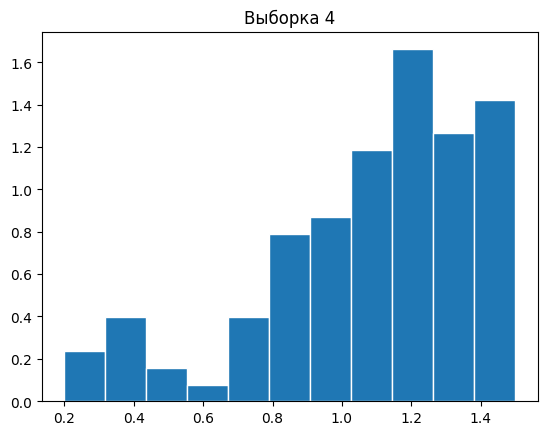

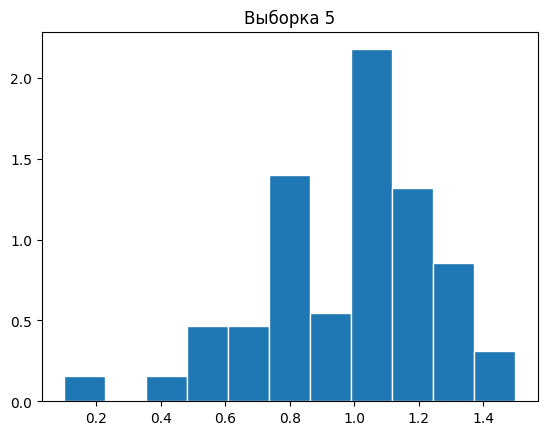

In [5]:
# читаю файл с данными
data = pd.read_excel('Data_7_1.ods')
table = pd.DataFrame(data)

# получаю выборки из данных
samples = []
for sample_name in table:
    samples.append(parse_sample(table[sample_name].dropna()))

# визуализирую выборки
for i in range(len(samples)):
    plt.figure()
    plt.title(f"Выборка {i + 1}")
    plt.hist(samples[i], bins='sqrt', edgecolor='w', density=True)

Среди данных выборок довольно сложно выбрать те, которые похожи на конкретные распределение (по крайней мере на равномерное). Сделаю следующие предположения:
- Выборка 2 распределена нормально
- Выборка 4 распределена равномерно
- Выборка 3 (преобразованная) распределена показательно

(array([2.20679012, 2.03703704, 1.78240741, 1.10339506, 0.93364198,
        0.50925926, 0.25462963, 0.16975309, 0.        , 0.        ,
        0.16975309]),
 array([0.        , 0.10909091, 0.21818182, 0.32727273, 0.43636364,
        0.54545455, 0.65454545, 0.76363636, 0.87272727, 0.98181818,
        1.09090909, 1.2       ]),
 <BarContainer object of 11 artists>)

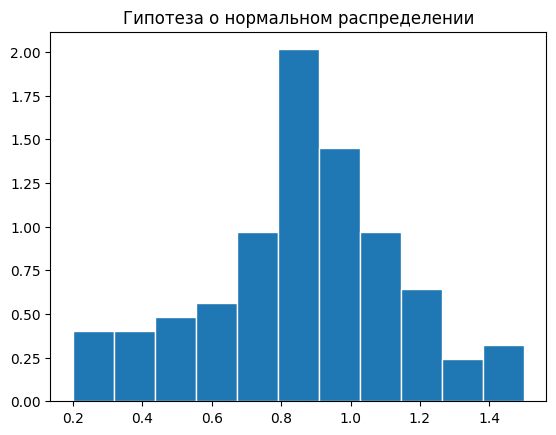

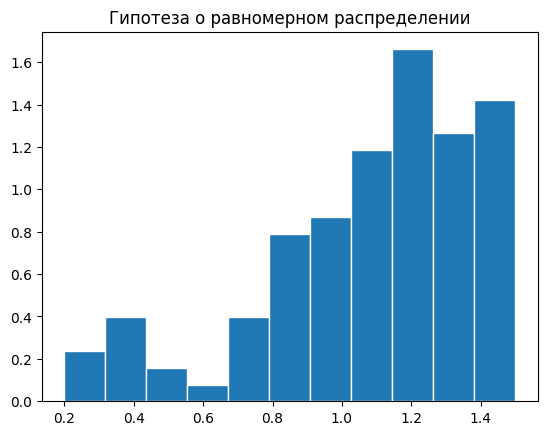

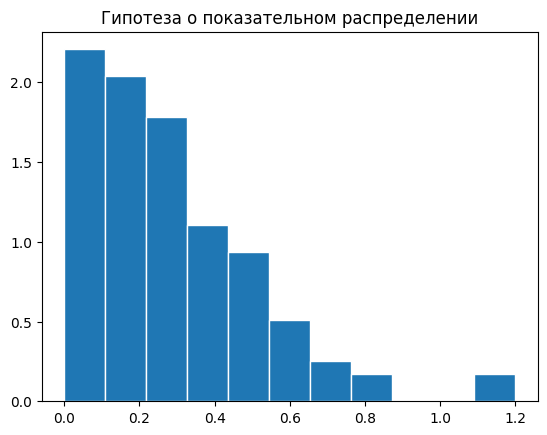

In [6]:
A = samples[1]
B = samples[3]
C = [max(samples[2]) - i for i in samples[2]]

plt.figure()
plt.title("Гипотеза о нормальном распределении")
plt.hist(A, bins='sqrt', edgecolor='w', density=True)

plt.figure()
plt.title("Гипотеза о равномерном распределении")
plt.hist(B, bins='sqrt', edgecolor='w', density=True)

plt.figure()
plt.title("Гипотеза о показательном распределении")
plt.hist(C, bins='sqrt', edgecolor='w', density=True)

### Задание 2
Проверьте гипотезу о том, что выборка А взята из генеральной совокупности, имеющей нормальное распределение, двумя способами:
- Используйте критерий согласия хи-квадрат. Решение должно быть подробным, с выполнением всех шагов алгоритма и отслеживанием корректности применения (без привлечения «готовых» инструментов языка программирования Python типа функции chisquare()). Сделайте выводы;
- Воспользуйтесь критерием Шапиро – Уилка (используйте функцию shapiro() модуля scipy.stats). Сделайте выводы.
Сопоставьте полученные при выполнении пп. 1) и 2) результаты.

In [30]:
# класс для представления результата критерия в красивом виде
class Chi2Result:
    def __init__(self, ssv, p, intervals, r, p_k, n_k, size):
        self.statistic = ssv
        self.pvalue = p
        self.intervals = intervals
        self.number_of_intervals = r
        self.th_prob = p_k
        self.n_k = n_k
        self.sample_size = size

# функция критерия Пирсона
def chi2_test(sample, expected_distribution, num_of_params, start=-np.inf, intervals=[],
              number_of_intervals=0):
    # сортируем выборку
    sample.sort()
    
    # функция вероятности на интервале для гипотетического распределения
    probability = lambda distr, x_1, x_2: distr.cdf(x_2) - distr.cdf(x_1)

    # интервалы (автоматическое разбиение, если инетрвалы не заданы изначально)
    if not len(intervals):
        intervals = [start]
        for elem in sample:
            elem = round(elem, 3)
            # условие np_k >= 5
            if probability(expected_distribution, intervals[-1],
                           elem) * len(sample) >= 5:
                intervals.append(elem)
        intervals[-1] = np.inf

        # случайное склеивание интервалов, если задано число и оно
        # не 0 и меньше, чем число интервалов полученных автоматически
        while 1 < number_of_intervals < len(intervals) - 1:
            intervals.pop(np.random.randint(1, len(intervals) - 1))
    
    # проверяем np_k >= 5 для заданной выборки
    else:
        for k in range(len(intervals) - 1):
            np_k = probability(expected_distribution, intervals[k],
                               intervals[k + 1]) * len(sample)
            if np_k < 5:
                return None

    # число интервалов
    r = len(intervals) - 1

    p_k = []
    n_k = []
    
    # вычисление выборочного значения статистики
    ssv = 0
    for k in range(len(intervals) - 1):
        elements_in = [i for i in sample if intervals[k] <= i < intervals[k + 1]]
        n_k.append(len(elements_in))
        p_k.append(probability(expected_distribution, intervals[k],
                           intervals[k + 1]))
        np_k =  p_k[-1] * len(sample)
        ssv += (n_k[-1] - np_k)**2 / np_k
    
    # p-значение
    p = 1 - sts.chi2(r - num_of_params - 1).cdf(ssv)

    return Chi2Result(ssv, p, intervals, r, p_k, n_k, len(sample))

def print_chi2_results(chi2_results):
    print("Промежуточные значения:")
    print(f"Количество интервалов: {chi2_results.number_of_intervals}")
    print(f"Интервал\tТеор. вероятность\tnp_k\t\t\tn_k")
    for i in range(len(chi2_results.intervals) - 1):
        if chi2_results.intervals[i] != np.inf:
            print(f"[{chi2_results.intervals[i]}, {chi2_results.intervals[i + 1]})", 
                  end='\t')
        else:
            print(f"({chi2_results.intervals[i]}, {chi2_results.intervals[i + 1]})", 
                  end='\t')
        print(chi2_results.th_prob[i], end='\t')
        print(chi2_results.th_prob[i] * chi2_results.sample_size, 
              end='\t')
        print(chi2_results.n_k[i], end='\t')
        print()

    print()
    print(f"Сумма теоретических вероятностей: {sum(chi2_results.th_prob)}")
    print(f"Значение статистики: {chi2_results.statistic}")

In [31]:
# уровень значимости
alpha = 0.05

# выборочные характеристики
m = np.mean(A)
sig = np.std(A, ddof=1)

# гипотетическое распределение
distribution = sts.norm(m, sig)

# критерий хи-квадрат
chi2_results = chi2_test(A, distribution, 2)

# критерий Шапиро-Уилка
shapiro_results = sts.shapiro(A)

# выводим p-значения на экран
print(f"p-значение по хи-квадрат: {chi2_results.pvalue}")
print(f"p-значение по Шапиро: {shapiro_results.pvalue}")
print()

# результаты проверки для заданного альфа
print("По критерию хи-квадрат гипотеза", end='')
if alpha < chi2_results.pvalue:
     print(" принимается")
else:
    print(" отклоняется")

print("По критерию Шапиро гипотеза", end='')
if alpha < shapiro_results.pvalue:
    print(" принимается")
else:
    print(" отклоняется")

print()
print_chi2_results(chi2_results)

p-значение по хи-квадрат: 0.43281954482953333
p-значение по Шапиро: 0.08102016896009445

По критерию хи-квадрат гипотеза принимается
По критерию Шапиро гипотеза принимается

Промежуточные значения:
Количество интервалов: 11
Интервал	Теор. вероятность	np_k			n_k
[-inf, 0.4)	0.050925906643886326	5.347220197608064	5	
[0.4, 0.5)	0.048908198672022035	5.135360860562313	5	
[0.5, 0.6)	0.07659664085370554	8.042647289639081	6	
[0.6, 0.7)	0.1060089760891556	11.130942489361338	7	
[0.7, 0.8)	0.1296530336294564	13.613568531092923	12	
[0.8, 0.9)	0.14013004638732163	14.71365487066877	12	
[0.9, 1.0)	0.13384092676665404	14.053297310498674	13	
[1.0, 1.1)	0.11296798126082142	11.86163803238625	18	
[1.1, 1.2)	0.08426153637635769	8.847461319517558	12	
[1.2, 1.3)	0.05554038712973952	5.83174064862265	8	
[1.3, inf)	0.061166366190879784	6.422468450042377	7	

Сумма теоретических вероятностей: 1.0
Значение статистики: 8.006662817506854


### Задание 3
Проверьте гипотезу о том, что выборка С (исходная или полученная путем преобразования) взята из генеральной совокупности, имеющей показательное распределение. Используйте критерий согласия хи-квадрат. Решение должно быть подробным, с выполнением всех шагов алгоритма и отслеживанием корректности применения. Сделайте
выводы.

In [25]:
# уровень значимости
alpha = 0.05

# выборочные характеристики
m = np.mean(C)

# гипотетическое распределение
distribution = sts.expon(0, m)

# критерий хи-квадрат
chi2_results = chi2_test(C, distribution, 1, start=0)

# выводим на экран p-значение
print(f"p-значение: {chi2_results.pvalue}")

# результаты проверки для заданного альфа
print("По критерию хи-квадрат гипотеза", end='')
if alpha < chi2_results.pvalue:
     print(" принимается")
else:
    print(" отклоняется")

print()
print_chi2_results(chi2_results)

p-значение: 1.3011813848606835e-13
По критерию хи-квадрат гипотеза отклоняется

Промежуточные значения:
Количество интервалов: 12
Интервал	Теор. вер.		np_k			n_k
[0, 0.03)	0.09327382641055454	10.07357325233989	6	
[0.03, 0.1)	0.18519709089687864	20.001285816862893	1	
[0.1, 0.15)	0.1086415862779303	11.733291318016473	21	
[0.15, 0.18)	0.057166361949778144	6.173967090576039	1	
[0.18, 0.23)	0.08367566467470844	9.036971784868511	24	
[0.23, 0.27)	0.057773670648855635	6.239556430076409	0	
[0.27, 0.35)	0.09519998385634998	10.281598256485797	18	
[0.35, 0.4)	0.04804306434853034	5.188650949641277	12	
[0.4, 0.47)	0.055357105248365346	5.978567366823457	2	
[0.47, 0.6)	0.07457293497591488	8.053876977398808	10	
[0.6, 0.75)	0.0546210751564411	5.899076116895639	8	
[0.75, inf)	0.08647763555569266	9.339584640014806	5	

Сумма теоретических вероятностей: 1.0
Значение статистики: 82.98606232491922


Что немного странно, получившаяся выборка похожа на показательную, а p-значение очень маленькое (при стандартных значениях $\alpha$ гипотеза о показательном распределении никогда не будет принята).

А теперь поэкспериментриую. В моей функции для критерия Пирсона используется автоматическое разбиение на интервалы, для которых выполняется условие $np_k \geq 5$, но это разбиение не учитывает количество интервалов и делает его практически максимальным. Для того, чтобы получить фиксированное количество интервалов из уже полученных, я добавил в функцию возможность "склеивать" "случайные" интервалы между собой. Очевидно, что при склеивании условие $np_k \geq 5$ не пострадает. Возьму какое-нибудь фиксированное число интервалов и несколько раз (множество интервалов будет каждый раз новое) применю функцию для критерия Пирсона на данной выборке. Понаблюдаю за p-значением.

In [8]:
# выборочные характеристики
m = np.mean(C)

# гипотетическое распределение
distribution = sts.expon(0, m)

# критерий хи-квадрат
chi2_results = chi2_test(C, distribution, 1, start=0)

# число интервалов
n = 6

# количество итераций
iterations = 1000

# ищем минимальное и максимальное значение p
min_p = 1
max_p = 0
for i in range(iterations):
    chi2_results = chi2_test(C, distribution, 1, start=0, number_of_intervals=n)
    p = chi2_results.pvalue
    if p > max_p: max_p = p
    if p < min_p: min_p = p

# вывод на экран
print(f"Минимальное значение p: {min_p}")
print(f"Максимальное значение p: {max_p}")
print(f"Разница между наибольшим полученным p и наименьшим: {max_p - min_p}")

Минимальное значение p: 4.3365311341858614e-13
Максимальное значение p: 0.509337989313469
Разница между наибольшим полученным p и наименьшим: 0.5093379893130353


Довольно интересный и странный результат. Разница существенная. Получается, примем мы гипотезу или отвергнем сильно зависит от разбиения множества на интервалы.

Попробую сгенерировать еще пару других выборок и проверить предположение.

In [9]:
# характеристики распределений
m = 5
sig = 4

# размеры выборок
size_1 = 100
size_2 = 1000

# названия выборок
texts = [f"Нормальное распределение с размером выборки {size_1}",
         f"Нормальное распределение с размером выборки {size_2}",
         f"Показательное распределение с размером выборки {size_1}",
         f"Показательное распределение с размером выборки {size_2}"]

# сами выборки (две нормальное, две показательные)
samples = []
samples.append(np.random.normal(m, sig, size_1))
samples.append(np.random.normal(m, sig, size_2))
samples.append(np.random.exponential(m, size_1))
samples.append(np.random.exponential(m, size_2))

# гипотетические распределения
distributions = []
distributions.append(sts.norm(samples[0].mean(), samples[0].std()))
distributions.append(sts.norm(samples[1].mean(), samples[1].std()))
distributions.append(sts.expon(0, samples[2].mean()))
distributions.append(sts.expon(0, samples[3].mean()))

# начала (откуда начинается область значений случайной величины)
starts = [-np.inf, -np.inf, 0, 0]

# количества неизвестных параметров
num_of_params = [2, 2, 1, 1]

In [10]:
# листы значений p
pvalues = [[], [], [], []]

# число интервалов
n = 6

# количество итераций
iterations = 100

# считаем значения p
for i in range(len(samples)):
    sample = samples[i]
    distribution = distributions[i]
    s = starts[i]
    params = num_of_params[i]
    
    for j in range(iterations):
        chi2_results = chi2_test(sample, distribution, params, start=s,
                                 number_of_intervals=n)
        pvalues[i].append(chi2_results.pvalue)

# выводим результаты на экран
for i in range(len(pvalues)):
    print(texts[i])
    print(f"Минимальное значение p: {min(pvalues[i])}")
    print(f"Максимальное значение p: {max(pvalues[i])}")
    print(f"Их разница: {max(pvalues[i]) - min(pvalues[i])}")
    print()

Нормальное распределение с размером выборки 100
Минимальное значение p: 0.2472342713365706
Максимальное значение p: 0.9230530135032933
Их разница: 0.6758187421667227

Нормальное распределение с размером выборки 1000
Минимальное значение p: 0.018535595852847586
Максимальное значение p: 0.9808110860064302
Их разница: 0.9622754901535826

Показательное распределение с размером выборки 100
Минимальное значение p: 0.018556854240952325
Максимальное значение p: 0.944757383134307
Их разница: 0.9262005288933547

Показательное распределение с размером выборки 1000
Минимальное значение p: 0.005028025378229439
Максимальное значение p: 0.9030311787964292
Их разница: 0.8980031534181998



Действительно, разбиение очень сильно влияет на получаемые p-значения. Если я нигде не ошибся, тогда у меня остается вопрос - а как правильно разбить множество возможных значений случайной величины на интервалы? Поиски в интернете привели к каким-то статьям, где в начале кратко говорится, что это неочевидный вопрос. Сами статьи пока не прочел, так что вопрос открытый, ведь если не учитывать разбиение и брать случайное (удовлетворяющее $np_k \geq 5$), то мы можем получить любой результат при стандартных значениях $\alpha$.

### Задание 4
В файле «Data_7_2» приведены два массива результатов наблюдения случайной величины. Будем рассматривать каждый из массивов X и XX как случайную выборку из генеральной совокупности с неизвестным законом распределения (для каждого массива генеральная совокупность своя).
- Преобразуйте данные, применив к каждой из выборок (X и XX) преобразование Бокса-Кокса (далее Y и YY – преобразованные данные).
- Постройте гистограммы X и Y, XX и YY. Сопоставьте гистограммы прообразов и образов. Результаты прокомментируйте.
- С помощью подходящего критерия проверьте для всех четырех выборок гипотезы о том, что выборки принадлежат нормально распределенным генеральным совокупностям. Результаты сопоставьте и прокомментируйте.
- Для всех четырех выборок постройте Q-Q – график. Сопоставьте графики прообразов и образов. Результаты прокомментируйте и со-
поставьте с результатами п. 3).

Значения p для оригинальных выборок:
Shapiro: 1.9879946194123477e-05
Shapiro: 6.563858914887533e-05

Значения p для преобразованных выборок:
Shapiro: 0.0001458106708014384
Shapiro: 0.0021331878378987312


<Figure size 640x480 with 0 Axes>

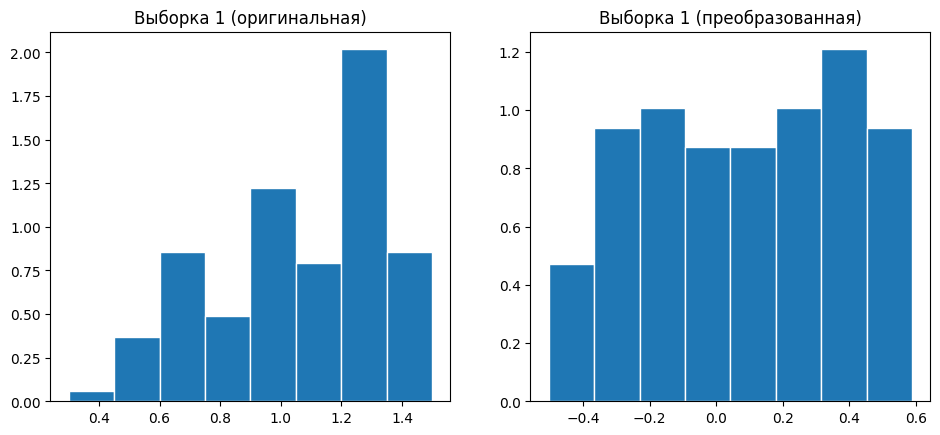

<Figure size 640x480 with 0 Axes>

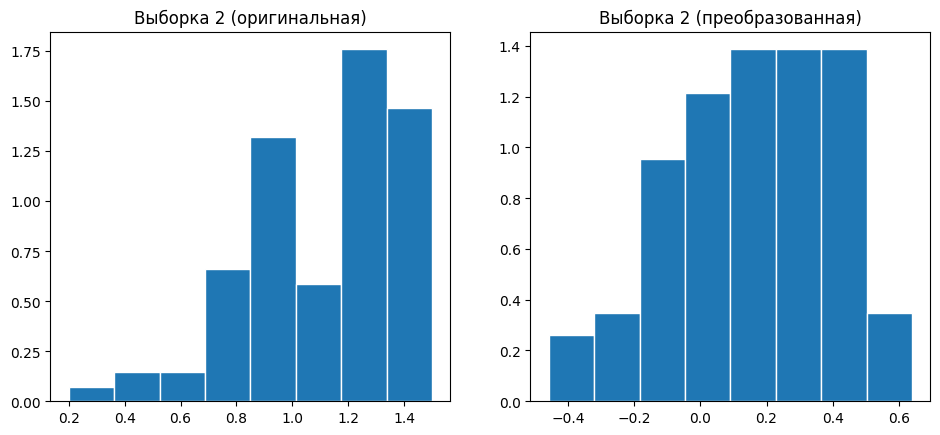

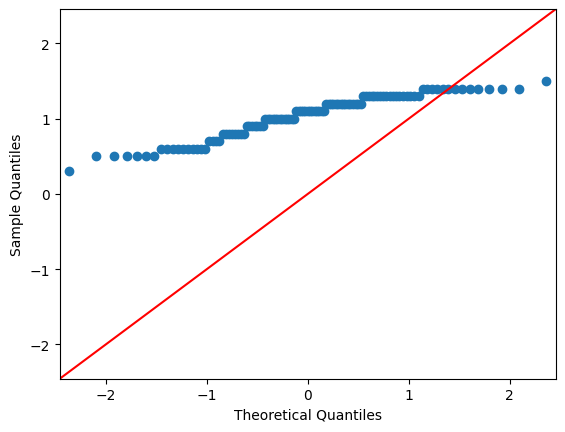

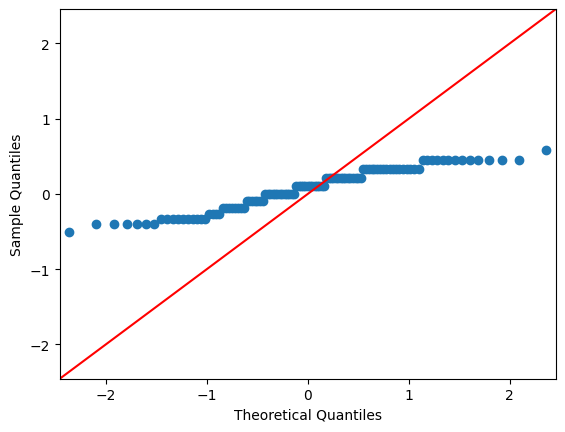

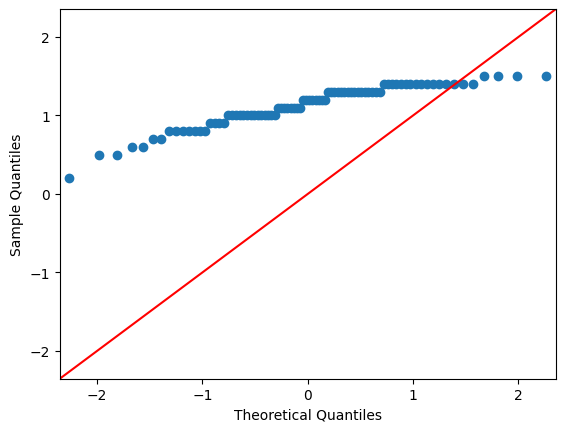

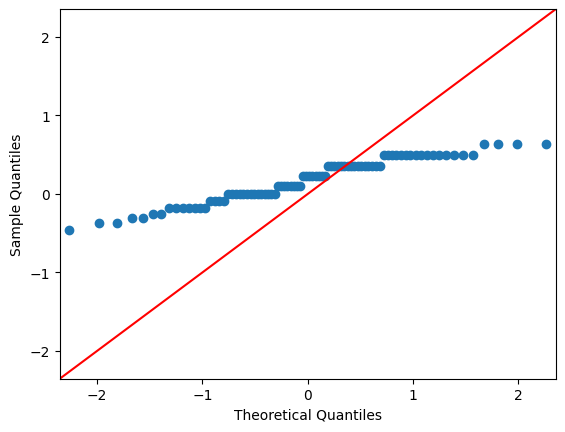

In [11]:
# читаю файл с данными
data = pd.read_excel('Data_7_2.ods')
table = pd.DataFrame(data)

# получаю выборки и их преобразованные версии из данных
samples = []
transformed_samples = []
for sample_name in table:
    sample = parse_sample(table[sample_name].dropna(), 1)
    samples.append(sample)
    transformed_samples.append(sts.boxcox(sample)[0])

# визуализирую выборки
for i in range(len(samples)):
    plt.figure()
    fig, sub_plt = plt.subplots(1, 2)
    plt.subplots_adjust(right=1.5)
    sub_plt[0].set_title(f"Выборка {i + 1} (оригинальная)")
    sub_plt[0].hist(samples[i], bins='sturges', edgecolor='w', density=True)
    sub_plt[1].set_title(f"Выборка {i + 1} (преобразованная)")
    sub_plt[1].hist(transformed_samples[i], bins='sturges', edgecolor='w', density=True)

print("Значения p для оригинальных выборок:")
for sample in samples:
    sgapiro_result = sts.shapiro(sample)
    print("Shapiro:", sgapiro_result.pvalue)

print()

print("Значения p для преобразованных выборок:")
for sample in transformed_samples:
    sgapiro_result = sts.shapiro(sample)
    print("Shapiro:", sgapiro_result.pvalue)
    
# проверить для всех выборок их нормальность и построить для каждой Q-Q график
plot_1 = sm.qqplot(np.array(samples[0]), line='45')
plot_2 = sm.qqplot(np.array(transformed_samples[0]), line='45')

plot_3 = sm.qqplot(np.array(samples[1]), line='45')
plot_4 = sm.qqplot(np.array(transformed_samples[1]), line='45')

Q-Q рафики идут в следующем порядке:
- Выборка 1 (оригинальная)
- Выборка 1 (преобразованная)
- Выборка 2 (оригинальная)
- Выборка 2 (преобразованная)

Можно заметить, что преобразование Бокса-Кокса действительно сделало выборки более нормальными. При проверке гипотезы о нормальности распределения значение p у преобразованных выборок выше, а графики стали более "симметричны".